In [ ]:
!git clone https://github.com/andyrdt/refusal_direction.git
%cd refusal_direction

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [ ]:
import os
import pickle
from pipeline.submodules.evaluate_jailbreak import evaluate_jailbreak
from pipeline import config
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
COMPLETIONS_PATH = "./completions_104.pkl"
model_path = 'Qwen/Qwen1.5-0.5B-Chat'
model_alias = os.path.basename(model_path)
cfg = config.Config(model_alias=model_alias, model_path=model_path, 
             jailbreak_eval_methodologies = ('substring_matching', 'harmbench'),
             refusal_eval_methodologies = ('substring_matching', 'harmbench'))
dataset_name = cfg.evaluation_datasets[0]

os.environ["TOGETHER_API_KEY"] = ''

In [ ]:
with open(COMPLETIONS_PATH, "rb") as f:
    all_completions = pickle.load(f)
all_completions 

In [ ]:
evals = {}
for completion_name, completions in all_completions.items():
  intervention_label = completion_name
  print(f'Running evals for {completion_name}:')
  evaluation_jailbreak = evaluate_jailbreak(
        completions=completions,
        methodologies=cfg.jailbreak_eval_methodologies[0],
        evaluation_path=os.path.join('./', "completions", f"{dataset_name}_{intervention_label}_evaluations.json"),
    )
  evaluation_refusal = evaluate_jailbreak(
        completions=completions,
        methodologies=cfg.refusal_eval_methodologies,
        evaluation_path=os.path.join('./', "completions", f"{dataset_name}_{intervention_label}_evaluations.json"),
    )
  evals[completion_name] = [evaluation_jailbreak, evaluation_refusal]
  print(evals[completion_name])
  print('=============================================\n')

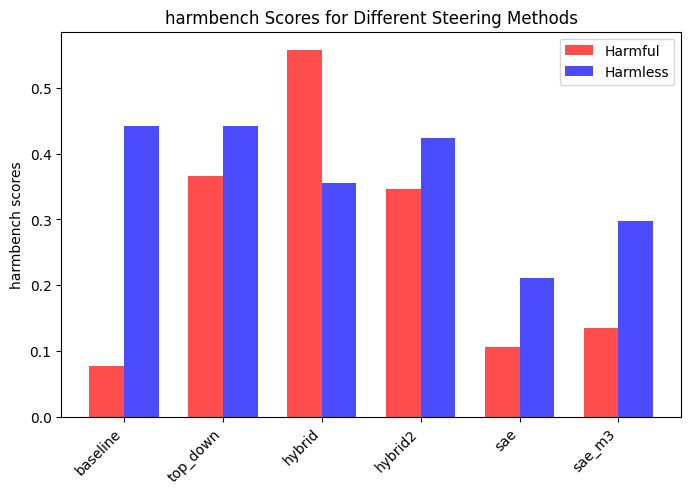

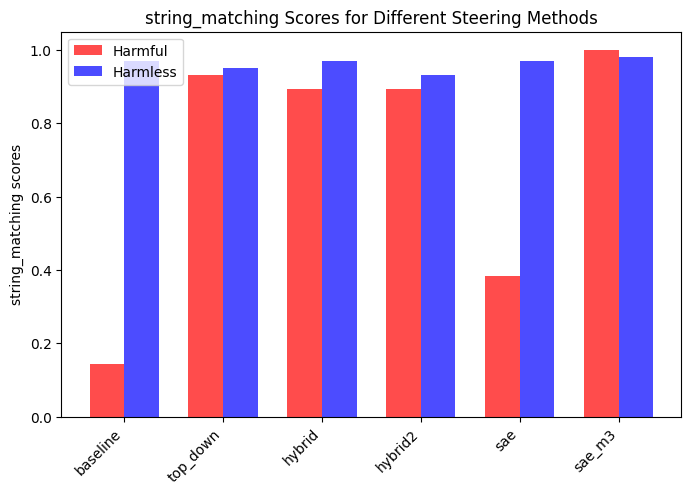

In [18]:
def get_refusal_scores(evals: dict, metric: str = 'harmbench', categorey:str = None):
    if '_per_category' in metric:
        assert categorey is not None, 'Please provide prompt category from harmful, harmless'
        return {steering_method: evals[steering_method][0][metric][categorey] for steering_method in evals}
    else:
        assert categorey is None, 'For prompt category to be considered, please specify "per_category" in metric name'
        return {steering_method: evals[steering_method][0][metric] for steering_method in evals}

def plot_refusal_scores(steering_scores_harmful: dict, steering_scores_harmless: dict, metric: str):
    """
    Plots a bar chart comparing refusal scores for harmful and harmless prompts 
    across different steering methodologies.
    
    Args:
    - steering_scores_harmful (dict): {methodology: score} for harmful prompts.
    - steering_scores_harmless (dict): {methodology: score} for harmless prompts.
    - metric (str): Name of the metric being plotted.
    """
    methodologies = list(steering_scores_harmful.keys())  # Get list of methodologies
    x = np.arange(len(methodologies))  # X positions for bars
    bar_width = 0.35  # Width of each bar

    # Extract scores
    harmful_scores = [steering_scores_harmful[method] for method in methodologies]
    harmless_scores = [steering_scores_harmless[method] for method in methodologies]

    fig, ax = plt.subplots(figsize=(8, 5))

    # Plot bars
    ax.bar(x - bar_width / 2, harmful_scores, width=bar_width, label="Harmful", color="red", alpha=0.7)
    ax.bar(x + bar_width / 2, harmless_scores, width=bar_width, label="Harmless", color="blue", alpha=0.7)

    # Formatting
    ax.set_xticks(x)
    ax.set_xticklabels(methodologies, rotation=45, ha="right")
    ax.set_ylabel(f"{metric} scores")
    ax.set_title(f"{metric} Scores for Different Steering Methods")
    ax.legend()

    plt.show()

harmful_harmbench_scores, harmless_harmbench_scores = get_refusal_scores(evals, 'harmbench_per_category', 'harmful'), get_refusal_scores(evals, 'harmbench_per_category', 'harmless')
harmful_sm_scores, harmless_sm_scores = get_refusal_scores(evals, 'substring_matching_per_category', 'harmful'), get_refusal_scores(evals, 'substring_matching_per_category', 'harmless')
plot_refusal_scores(harmful_harmbench_scores, harmless_harmbench_scores, 'harmbench')
plot_refusal_scores(harmful_sm_scores, harmless_sm_scores, 'string_matching')